In [1]:
# Data Import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from time import time 

print "importing biology"
biology = pd.read_csv("data/biology.csv")
print "importing crypto"
crypto = pd.read_csv("data/crypto.csv")
print "importing robotics"
robotics = pd.read_csv("data/robotics.csv")
print "importing diy"
diy = pd.read_csv("data/diy.csv")    
print "importing cooking"
cooking = pd.read_csv("data/cooking.csv")
print "importing travel"
travel = pd.read_csv("data/travel.csv")
    
print "importing physics test set"
test = pd.read_csv("data/test.csv") 



importing biology
importing crypto
importing robotics
importing diy
importing cooking
importing travel
importing physics test set


In [2]:
df_hash = {
    "cooking": cooking,
    "crypto": crypto,
    "robotics": robotics,
    "biology": biology,
    "travel": travel,
    "diy": diy,
}

In [3]:
# Data Exploration

print df_hash['biology'].columns.values

print biology.head(5)

print "\nNumber of rows by topic"
counter = 0

for topic, df in df_hash.iteritems():
    topic_length = len(df.index)
    print topic + ": " +  str(topic_length)
    counter += topic_length

print "\ntotal number of questions:"
print counter

print "testing set data shape:"
print test.shape

['id' 'title' 'content' 'tags']
   id                                              title  \
0   1  What is the criticality of the ribosome bindin...   
1   2  How is RNAse contamination in RNA based experi...   
2   3      Are lymphocyte sizes clustered in two groups?   
3   4  How long does antibiotic-dosed LB maintain goo...   
4   5        Is exon order always preserved in splicing?   

                                             content  \
0  <p>In prokaryotic translation, how critical fo...   
1  <p>Does anyone have any suggestions to prevent...   
2  <p>Tortora writes in <em>Principles of Anatomy...   
3  <p>Various people in our lab will prepare a li...   
4  <p>Are there any cases in which the splicing m...   

                                                tags  
0  ribosome binding-sites translation synthetic-b...  
1                                   rna biochemistry  
2                 immunology cell-biology hematology  
3                                       cell-cultu

In [4]:
import nltk
# When running this notebook for first time,
# uncomment command below, select "stopwords" in gui, and follow prompt to download

# nltk.download()
from nltk.corpus import stopwords

# In Python, searching a set is much faster than searching a list, so convert the stop words to a set
stops = set(stopwords.words("english"))  

In [5]:
# Data Preprocessing methods

from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer

def separate_tags(tags):
    return tags.split(" ")

def clean_data(raw_data):
    if raw_data:
        # remove html tags & code snippets
        soup = BeautifulSoup(raw_data, "html.parser")

        [s.extract() for s in soup(['pre', 'code'])]
            
        question_text = soup.get_text()
        
        # remove everything but letters
        letters_only = re.sub("[^a-zA-Z]", " ", question_text) 
            
        # normalize case
        words = letters_only.lower().split()   

        # remove stopwords         
        meaningful_words = [w for w in words if not w in stops] 
        
        # remove permutations of the same word by reducing it to its stem
        wordnet_lemmatizer = WordNetLemmatizer()
        meaningful_word_stems = map(lambda x: wordnet_lemmatizer.lemmatize(x) , 
                                    meaningful_words)
        return( " ".join( meaningful_word_stems )) 
    else:
        return ""

In [6]:
# Data Preprocessing

# training set
for topic, df in df_hash.iteritems():
    df.content = df.content.apply(lambda x: clean_data(x) )
    df.title = df.title.apply(lambda x: clean_data(x) )
    df.tags = df.tags.apply(lambda y: separate_tags(y) )
    # drop rows without tags
    df.tags.replace(['', ' ', 'untagged'], np.nan, inplace=True)
    df.dropna(subset=['tags'], inplace=True)
    

# testing set
test.content = test.content.apply(lambda x: clean_data(x) )
test.title = test.title.apply(lambda x: clean_data(x) )

In [7]:
# Data Visualization methods

%matplotlib inline
import matplotlib.pyplot as plt

def top_tfidf_feats(row, features, top_n=20):
    # Get top n tfidf values in row and return them with their corresponding feature names
    topn_indicies = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_indicies]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_feats(dfs):
    x = np.arange(len(dfs["feature"]))
    fig = plt.figure(figsize=(12, 14), facecolor="w")

    ax = fig.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_frame_on(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
    ax.set_title( str(dfs.label), fontsize=16)
    ax.barh(x, dfs["tfidf"], align='center', color='#3F5D7D')
    ax.set_yticks(x)
    ax.set_ylim([-1, len(x) +1])
    ax.set_xlim([0, 7])
    yticks = ax.set_yticklabels(dfs["feature"])
    plt.show()
    fig_file_name = str(dfs.label) + '_tfidf.png'
    plt.savefig(fig_file_name)

In [8]:
# Data Visualization methods II

from wordcloud import WordCloud

def print_wordcloud(dfs):
    text = ' '.join(str(x) for x in dfs.tags.values) 
    
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0, max_words=100,
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    fig_file_name = str(dfs.label) + '_wordcloud.png'
    plt.savefig(fig_file_name, bbox_inches='tight')

biology
Finding terms with top tf-idf from question's titles


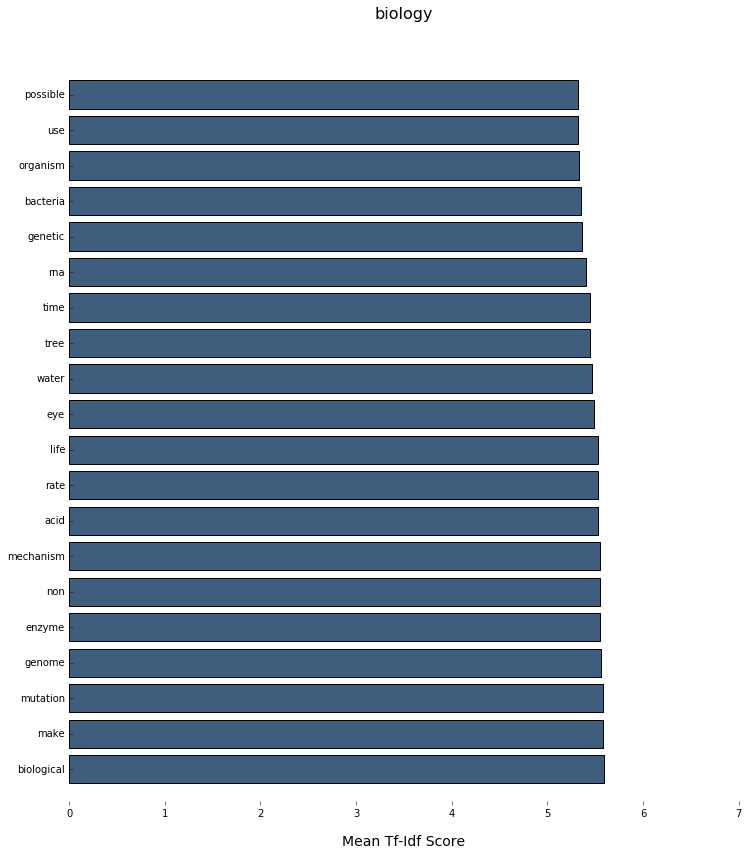

Finding most popular tags


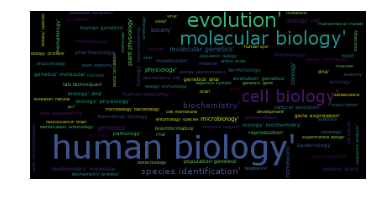

cooking
Finding terms with top tf-idf from question's titles


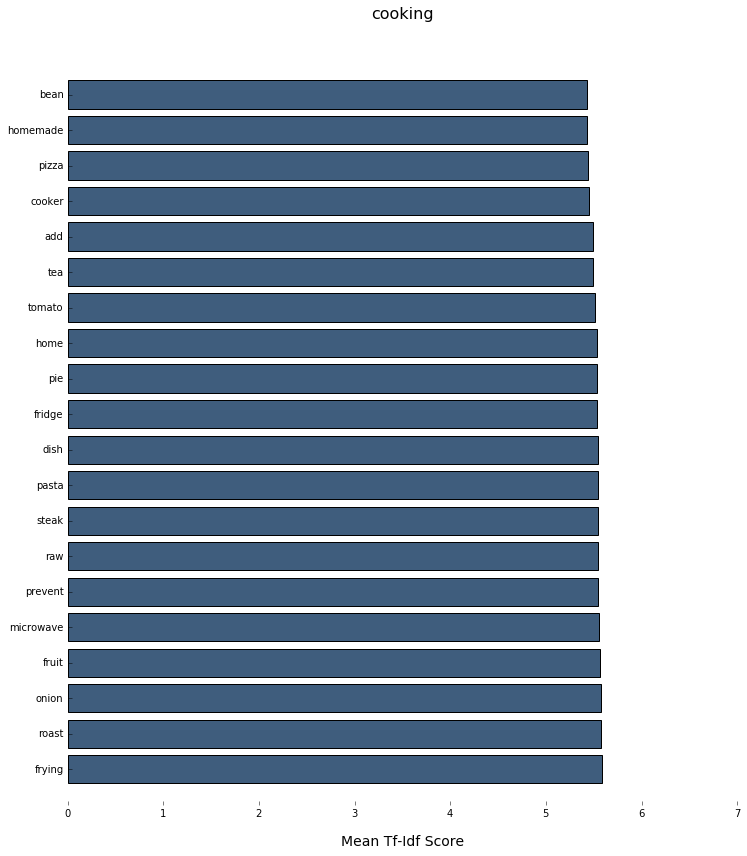

Finding most popular tags


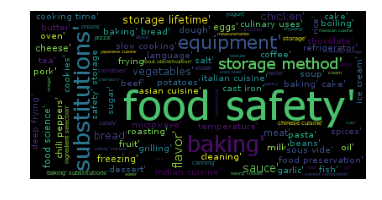

travel
Finding terms with top tf-idf from question's titles


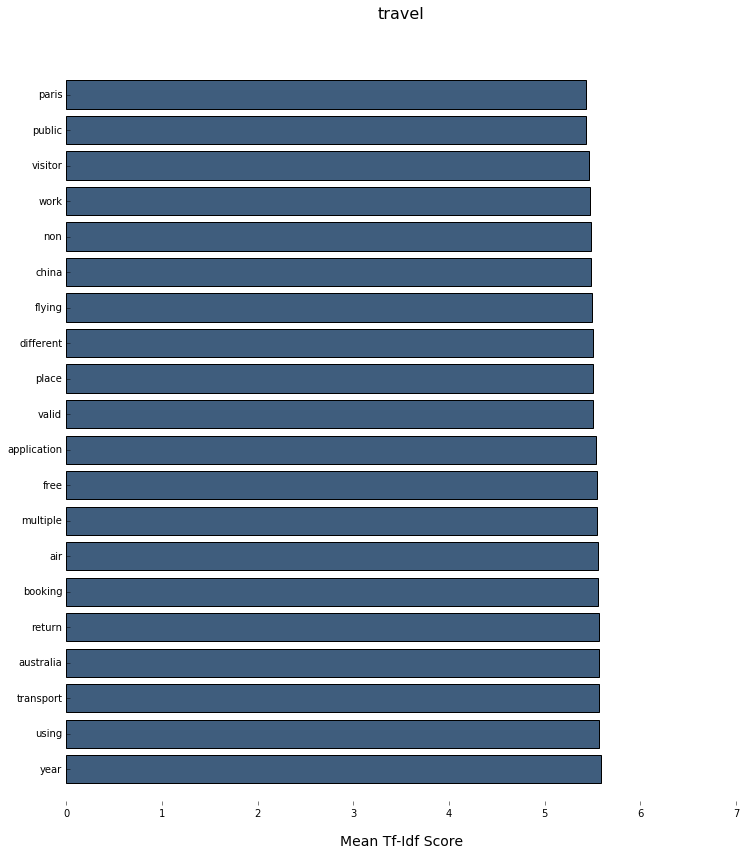

Finding most popular tags


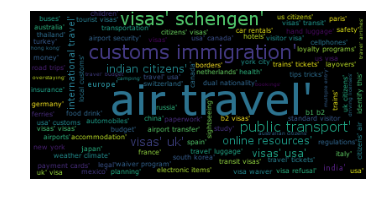

robotics
Finding terms with top tf-idf from question's titles


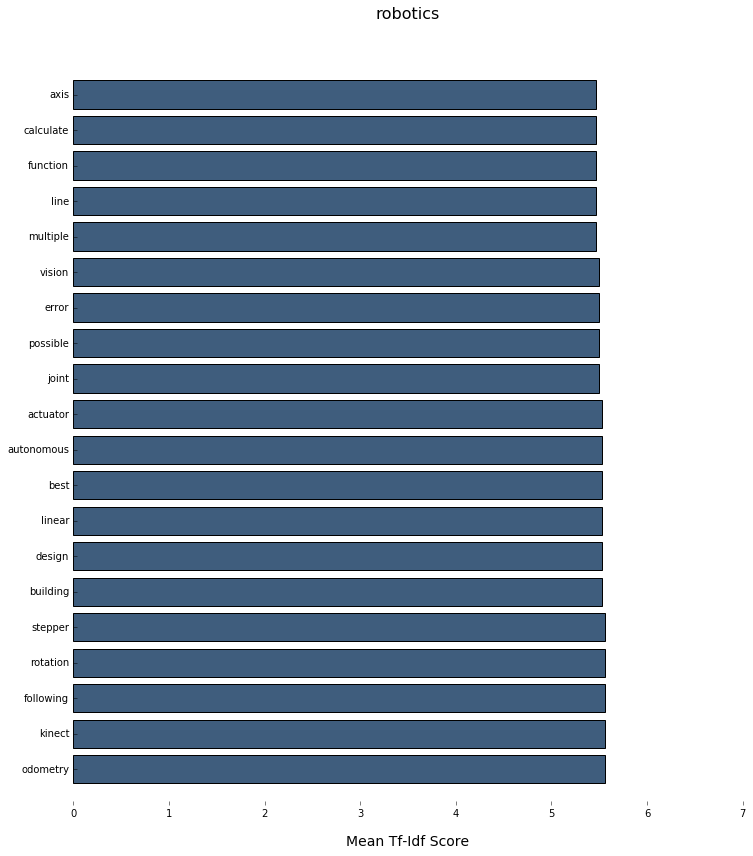

Finding most popular tags


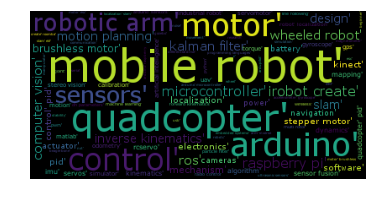

crypto
Finding terms with top tf-idf from question's titles


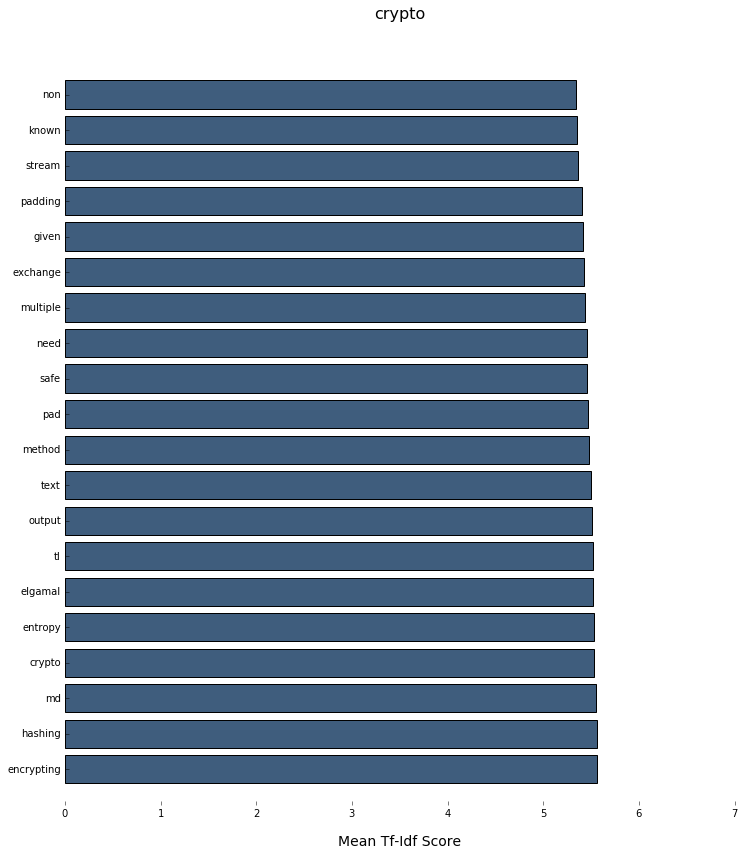

Finding most popular tags


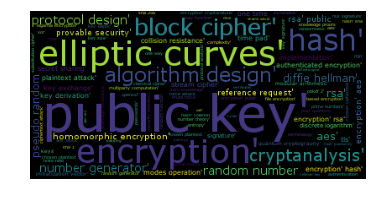

diy
Finding terms with top tf-idf from question's titles


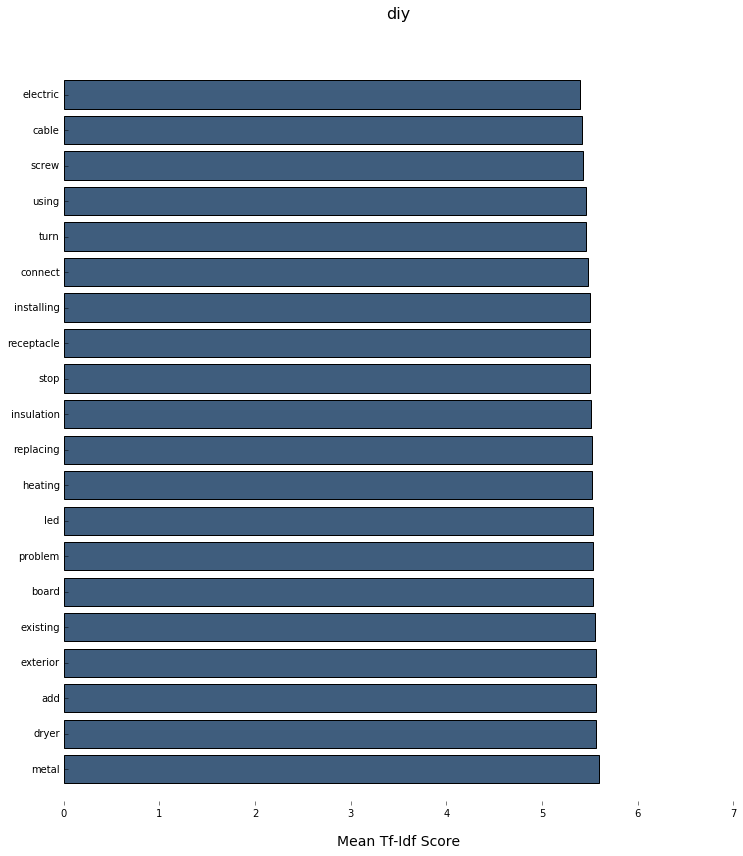

Finding most popular tags


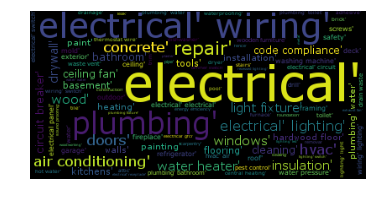

In [9]:
# Data Visualization

from sklearn.feature_extraction.text import TfidfVectorizer

vect_hash = {}

for topic, df in df_hash.iteritems():
    vect_hash[topic] = TfidfVectorizer( lowercase=True , stop_words="english" ,min_df=.01, max_df= .95 ) 
    X = vect_hash[topic].fit_transform(df.title)

    dfs = top_tfidf_feats( vect_hash[topic].idf_ , vect_hash[topic].get_feature_names()  ) 
    dfs.label = topic
    df.label = topic
    print topic
    print "Finding terms with top tf-idf from question's titles"
    plot_tfidf_feats(dfs)
    print "Finding most popular tags"
    print_wordcloud(df)        

In [10]:
# combine dataframes into one

frames = []
for topic, df in df_hash.iteritems():
    frames.append(df)

df_all = pd.concat(frames)

In [ ]:
# subset dataframes by key (content or title)

from sklearn.base import BaseEstimator, TransformerMixin
    
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [ ]:
# Implementation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer, accuracy_score, confusion_matrix

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.tree import DecisionTreeClassifier

parameters = {
    "union__title__tfidf__min_df" : [ 0.001, 0.005, 0.01 , 0.05],
    "union__title__tfidf__max_df" : [0.9, 0.95 , 0.975],
    "union__content__tfidf__min_df" : [ 0.001, 0.005, 0.01 , 0.05],
    "union__content__tfidf__max_df" : [0.9, 0.95 , 0.975],
    "DT__estimator__max_depth" : [5, 10, 25, 30],
    "DT__estimator__criterion" : ["gini", "entropy"],
    "union__transformer_weights" :  [{"title": 0.6, "content": 0.4},
                                    {"title": 0.75, "content": 0.25}]
}
steps = \
    [('union', FeatureUnion(
        transformer_list=[
            # Pipeline for tfidf vectorization of the question's title
            ('title', Pipeline([
                ('selector', Selector(key='title')),
                ('tfidf', TfidfVectorizer(lowercase=True, 
                                          stop_words="english") )
            ])),
            # Pipeline for tfidf vectorization of the question's content
            ('content', Pipeline([
                ('selector', Selector(key='content')),
                ('tfidf', TfidfVectorizer(lowercase=True,
                                          stop_words="english") )
            ]))
        ])),
    ("DT", OneVsRestClassifier(DecisionTreeClassifier( random_state = 42)))]



mlb = MultiLabelBinarizer()
Y =  pd.DataFrame(mlb.fit_transform(df_all.tags) )

t0 = time()
pipeline = Pipeline(steps)
clf = GridSearchCV(pipeline, parameters, cv=3, scoring='f1_weighted')
clf.fit( df_all, Y )
print("done in %0.3fs" % (time() - t0))

# referenced for pipeline and parameter construction:
# www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/


In [ ]:
# print best gridsearch score from cross validation and parameters

print("Best score: %0.3f" % clf.best_score_)
print("Best parameters set:")
best_parameters = clf.best_estimator_.get_params()
print "\n\n"
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
print "testing/predicting"

t0 = time()
y_prediction =  clf.predict(test)
print("done in %0.3fs" % (time() - t0))

Y_inv = mlb.inverse_transform(y_prediction)

In [ ]:
# index = 1
# y = mlb.inverse_transform(Y)
# for actual, pred in zip(df_all.tags, Y_inv):
#         print('index: {0} :: {1} => {2}'.format(index, actual, ', '.join(pred)))
#         index = index +1

In [ ]:
# write predictions to CSV

df_out = pd.DataFrame(columns=['id', 'tags'])

for y, t in zip(Y_inv, test.id):
    temp_hash = {'id': t,
            'tags': ' '.join(map(lambda x:  "".join(x) , y))}
    df_out = df_out.append(temp_hash,ignore_index=True)

    
df_out.id = df_out.id.astype(int)
df_out.to_csv("physics_predictions.csv", index = False)

In [ ]:
# print decision tree visualizations

from sklearn import tree
import pydot

index = 0
while index < 5 :
    fileStr = "tree" + str(index) + ".dot"
    with open(fileStr, "w") as output_file:
        tree.export_graphviz(clf.best_estimator_.named_steps['DT'].estimators_[index], class_names=mlb.classes_, out_file=output_file)

    (graph,) = pydot.graph_from_dot_file(fileStr)
    graph.write_png("tree" + str(index) + '.png')
    
    index += 1
    